# Recurrent Neural Networks on Stock Prediction v2

Thesis: NN can better identify patterns within the stock market, because they are able to analyse data at dimensions higher than 3 very easily. People are only able to perceive up to 3 dimensions, which limits our ability to identify patterns within a multi-dimensional data set

Practice: Build a RNN for a single stock. See if it can identify whether a stock will rise by 1% within 5 days.

Steps:
- Clean data set to include OHLC on a per day basis
- Create flag for each day if stock hits target within 5 days
- Build RNN for single stock
- Consider LSTM - if needed
- Expand to include multiple stocks (start with 10)
    - Check if other stock characteristics are important (industry, business model, volatility, etc.)
- Expand to include multiple day windows (3 days, 10 days, 1 day, etc.) See if predictions are more accurate for these multiple windows
- Expand to include multiple buffers (2%, 5%, 10%, etc.). 
    - Note: Of course a 10% rise in 5 days is very unlikely, but perhaps the model is able to predict these flags with higher precision?

In [1]:
# Import the required packages

# This is my personal functions list
import stock_trading_functions as fn

import numpy as np
from numpy import array, argmax

import pandas as pd
from pandas import DataFrame, read_csv
from pandas_datareader import data, wb

import matplotlib.pyplot as plt

from datetime import datetime

from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, LSTM, TimeDistributed, Flatten
from keras.utils import to_categorical, plot_model

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import graphviz
import pydot
import time

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The model:

I'm going to build a Long-Short Term Memory Neural Network.

The data:
Each data sample will represent `p` days previous of trading information (OHLC) for a particular stock. The model will predict whether the stock will be able to go up `target`% within `window` number days.

For now, we'll set the following hyperparameters:

In [2]:
# Set our hyperparameter variables

# For now we'll just pick one stock. Later, I'll want to add a list of multiple stocks
tickers = ["XOM"] # Sample stock to play with
target = .01     # Target to identify if stock increased by 1%
window = 5       # Window to identify whether stock hit target within these number of days
p = 90           # number of days of data for each data point

In [3]:
# Load the OHLC data into the variable data

data_source = 'morningstar'
start_date = datetime(2010, 1, 1)
end_date = datetime(2018, 3, 30)

data = data.DataReader(tickers, data_source, start_date, end_date)
column_labels = data.columns

In [4]:
data.describe()

,Close,High,Low,Open,Volume
count,2151.000000,2151.000000,2151.000000,2151.000000,2.151000e+03
mean,83.652650,84.193785,83.043640,83.626437,1.509283e+07
std,9.586854,9.571258,9.595647,9.579110,8.423556e+06
min,56.570000,56.990000,55.940000,56.850000,0.000000e+00
25%,79.600000,80.165000,78.820000,79.640000,9.972062e+06
50%,84.800000,85.340000,84.130000,84.790000,1.320044e+07
75%,89.530000,89.950000,88.857500,89.450000,1.841606e+07
max,104.380000,104.760000,103.950000,104.420000,1.180235e+08


In [5]:
# Convert data from pandas into numpy

datanp = data.values
print(datanp.shape)

(2151, 5)


In [6]:
# Create variables for creating flag column

trading_days = {}
for stock in tickers:
    trading_days[stock] = data.loc[stock].shape[0]
print(trading_days)

open_price = datanp[:, 3]
high = datanp[:, 1]
is_sellable = np.zeros((open_price.size, 1))

# For loop to add the column with flags to identify if stock will hit target within window
for index in range(0, trading_days[tickers[0]]):
    
    end = min(index + window, trading_days[tickers[0]])
    
    high_window = high[index:end]
    if sum(high_window > open_price[index] * (1+target)) > 0:
        is_sellable[index, 0] = 1
datanp = np.concatenate((datanp, is_sellable), axis = 1)
column_labels.append(pd.Index(["is_sellable"]))

{'XOM': 2151}


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'is_sellable'], dtype='object')

In [7]:
# Export semi-raw data into Excel to check
filepath = 'raw_data.xlsx'
writer = pd.ExcelWriter(filepath)

# Save y in first tab
rawData = pd.DataFrame(datanp)
rawData.to_excel(writer, sheet_name='rawdata', index=False)

# Save the Excel file
writer.save()

In [8]:
# Create columns with % change in prices, instead of raw price numbers

datanp = fn.create_columns(datanp, columns = "OHLC")

In [9]:
# Normalize the data

datanp = fn.normalize(datanp)

In [10]:
# Creating variable for number of examples

m = sum(trading_days.values()) - len(tickers) * (p + window - 1)
features = datanp.shape[1] - 1

In [11]:
# Re-shaping the data set. Each row should represent `window` days of trading data and the sell flag.

data = np.zeros((m, p + 1, features))   # Add on y into the p-dimension so we can shuffle the dataset together, then separate out y
Y = np.zeros((m))

for stock in tickers:
    for i in np.arange(m):
        data[i, :p, :] = datanp[i:(i+p), :features]
        data[i, -1, :] = [datanp[i+p-1, -1], 0, 0, 0]
        #data[i, -1, :] = np.reshape(datanp[i+p-1, -1], (1, features))

In [12]:
np.random.shuffle(data)

In [13]:
X = data[:, :p, :]
Y = np.reshape(data[:, -1, 0], (X.shape[0]))

print(X.shape)
print(Y.shape)

(2057, 90, 4)
(2057,)


In [14]:
# Check the data in Excel
filepath = 'check_data.xlsx'
writer = pd.ExcelWriter(filepath)

# Save y in first tab
dfY = pd.DataFrame(Y)
dfY.to_excel(writer, sheet_name='y', index=False)

# Save X labels in subsequent tabs
for i in np.arange(X.shape[2]):
    dfX = pd.DataFrame(X[:, :, i])
    dfX.to_excel(writer, sheet_name=str(i), index=False)

# Save the Excel file
writer.save()

## Encoding stock symbols into machine-readable categories
The stock symbol should also be an input in the machine learning model. My hypothesis is that each company's stock will have different patterns, so it's important for the model to identify those differences.

We'll need to encode the name of the stock into a machine-readable format. 

We can consider using one-hot encoding, but if eventually we feed in thousands of stock symbols, this creates a very high-dimension one-hot encoding, which will slow down the model significantly.

We can also consider using feature hashing. Research has shown this can significantly reduce the resouces needed to train the model. There is an issue of "collision" - but research has shown this doesn't reduce performance (check out: https://dzone.com/articles/feature-hashing-for-scalable-machine-learning). There's also the issue that we won't understand what the feature hash means. We'll save this for later, as I'm not familiar with this functionality yet.

I am also considering using binary encoding (for example: [0 1 0 1 0 1 0 0 1 1 1 0 0 0]) to represent the stock symbols. However, initial conversations state that this would require a deeper neural network. Because categories then share some of the same features, a deeper network can "disentangle" these categories.

Initial conversation on requiring deeper networks for binary encoding. Will need to find more research to back this up: https://stackoverflow.com/questions/40207422/binary-numbers-instead-of-one-hot-vectors/40208528#40208528

Some research papers on binary encoding:
https://www.researchgate.net/profile/Kedar_Potdar/publication/320465713_A_Comparative_Study_of_Categorical_Variable_Encoding_Techniques_for_Neural_Network_Classifiers/links/59e6f9554585151e5465859c/A-Comparative-Study-of-Categorical-Variable-Encoding-Techniques-for-Neural-Network-Classifiers.pdf

For now, we'll start with one-hot encoding and keep our universe of stocks to <50.

In [15]:
# One hot encoding of the stock symbols

values = array(tickers)

# Integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

# Binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
ohe_tickers = onehot_encoder.fit_transform(integer_encoded)

# Create a dictionary mapping the tickers to their one-hot encodings
ticker_dict = {}

for index, company in pd.Series(tickers).items():
    ticker_dict[company] = ohe_tickers[index]

In [16]:
# Append ohe_tickers to data

# ohe_list = []

# for index, company in pd.Series(tickers).items():
    # ohe_list.append(pd.concat([pd.Series(ticker_dict[company]).T] * time_index_AAPL.size, axis = 1).T)

# ohe_table = pd.concat(ohe_list, ignore_index=True)

# ohe_table.index = data.index

In [17]:
# Append the ohe_table to the data table
# data = pd.concat([ohe_table, data], ignore_index=True, axis=1)

In [18]:
# Rename columns in data table
# data.columns = ['ohe1', 'ohe2', 'ohe3', 'ohe4', 'ohe5', 'ohe6', 'ohe7', 'ohe8', 'ohe9', 'ohe10', 'Close', 'High', 'Low', 'Open', 'Volume', 'is_sellable']

In [19]:
# Ensure ohe section has been added correctly

#for stock in tickers:
# sum ohe1-ohe10 across rows for each stock, see if they equal ticker_dict

We'll need to split our data set into a training, development and test set.

We have to convert the data into numpy (from pandas) and reshape them into 3 dimensions to fit through LSTM. I'm not entirely sure why yet, but let's just try to see if it works for now.

In [21]:
# Split our data set into train/dev/test sets based on indicated split %.

pct_train = .90
pct_dev = .05
pct_test = 1 - pct_train - pct_dev

In [22]:
# Index of separation points within the index
train_dev_idx_num = int(pct_train * m)
dev_test_idx_num = int((pct_train + pct_dev) * m)

# Split the data as per proportions above
X_train = X[:train_dev_idx_num, :, :]
Y_train = Y[:train_dev_idx_num]

X_dev = X[train_dev_idx_num:dev_test_idx_num, :, :]
Y_dev = Y[train_dev_idx_num:dev_test_idx_num]

X_test = X[dev_test_idx_num:, :, :]
Y_test = Y[dev_test_idx_num:]

# Question: How do we use the dev set again?

In [23]:
# Make sure dimensions are correct
for i in [X_train, Y_train, X_dev, Y_dev, X_test, Y_test]:
    display("shape: {}".format(i.shape))

'shape: (1851, 90, 4)'

'shape: (1851,)'

'shape: (103, 90, 4)'

'shape: (103,)'

'shape: (103, 90, 4)'

'shape: (103,)'

Now we'll begin building our model.

In [24]:
# Function for setting up the model architecture

def model_setup(layers = 2):

    return_sequences = False
    
    if layers == 2:
        return_sequences = True
        
    model = Sequential()
    model.add(LSTM(output_dim = 50, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = return_sequences))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))

    if layers == 2:
        model.add(LSTM(100, return_sequences = False))
        model.add(Activation("relu"))
        model.add(Dropout(0.2))

    model.add(Dense(1, activation="sigmoid"))
    
    return model

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(90, 4), return_sequences=False, units=50)`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11000     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________
Baseline accuracy: 0.6188624210014584
Model compilation time :  0.09524703025817871
Epoch 1/10
1851/1851 [==============================] - 7s 4ms/step - loss: 0.6416 - acc: 0.6591
Epoch 2/10
1851/1851 [==============================] - 5s 3ms/step - loss: 0.5897 - acc:

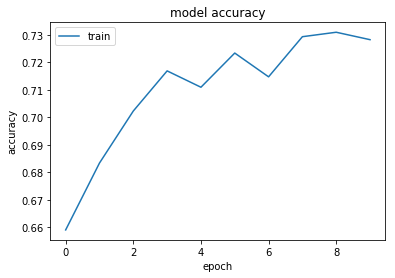

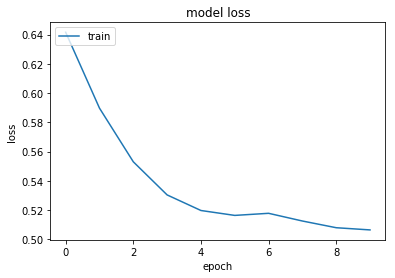

In [25]:
# Create a 1 layer model, and see how it performs.
model1 = model_setup(layers = 1)
model1.summary()
print("Baseline accuracy: {}".format(np.average(Y)))

# Train the model
start = time.time()
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print ('Model compilation time : ', time.time() - start)
history1 = model1.fit(X_train, Y_train, epochs=10, batch_size=32)
print ('Model fit time : ', time.time() - start)

# Evaluate the model
score = model1.evaluate(X_test, Y_test, batch_size=128)
print(score)
fn.plot_loss(history1)

plot_model(model1, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

<img src="model_plot1.png" style="width:300px;height:900px;">

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(90, 4), return_sequences=True, units=50)`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 90, 50)            11000     
_________________________________________________________________
activation_2 (Activation)    (None, 90, 50)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               60400     
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total para

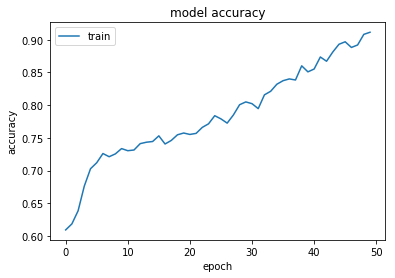

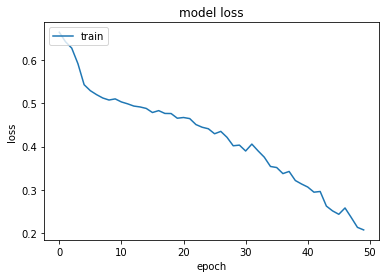

In [26]:
# Create a 2 layer model, and see how it performs.
model2 = model_setup(layers = 2)
model2.summary()
print("Baseline accuracy: {}".format(np.average(Y)))

# Train the model
start = time.time()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print ('Model compilation time : ', time.time() - start)
history2 = model2.fit(X_train, Y_train, epochs=50, batch_size=32)
print ('Model fit time : ', time.time() - start)

# Evaluate the model
score = model2.evaluate(X_test, Y_test, batch_size=128)
print(score)
fn.plot_loss(history2)

plot_model(model2, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

<img src="model_plot2.png" style="width:300px;height:900px;">

Further investigations:
- Review for any other journals on RNN models on stock data
- Check other ML models - what did they do? What did they include? What did they not include? And why?
- Do we need to add some drop out blocks? Drop out blocks help with regularization. But given that there is so much noise in stock data, is this required?
- Do I need to further update the data so that it's not just raw prices, but daily changes, volumes, distance, etc.?

This research was inspired by the following papers:
- https://pdfs.semanticscholar.org/6ea2/b0f7f9de845790d9add00a0a103f9d3242b5.pdf